# Natural Gas Price Analysis and Forecasting

This notebook analyses the historical prices of natural gas and forecasts future prices using time series analysis. The data includes monthly snapshots of natural gas prices from October 31, 2020, to September 30, 2024. The goal is to estimate the purchase price of natural gas for any date in the past and extrapolate the prices for one year into the future.

## Overview

1. **Introduction**: Overview of the report and objectives.
2. **Import Libraries and Load Data**: Import necessary libraries and load the dataset.
3. **Load and Inspect the Data**: Check the data structure, data types, missing values, and duplicates.
4. **Exploratory Data Analysis (EDA)**: Visualise the data to identify trends, seasonality, and other patterns.
5. **Stationarity Check**: Perform statistical tests to check if the time series is stationary.
6. **Model Selection**: Use Auto ARIMA to select the best model parameters.
7. **Model Evaluation**: Evaluate the performance of the selected model using cross-validation.
8. **Model Forecast**: Forecast future natural gas prices and visualise the results.

## 1. Import Libraries and Load Data

We start by importing necessary libraries and loading the data from a CSV file.


In [628]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Step 2: Load and Inspect the Data

Load the natural gas price data and inspect its structure.

In [630]:
# Load the data file
data_path = 'Nat_Gas.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the data
data.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


### Check for Missing Values and Data Types

Inspect the data types and check for missing values and duplicates.

In [632]:
# Inspect the data types and check for missing values
print(data.info())

# Check for missing values
data.isnull().sum()

# Check for duplicate
data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes
None


0

### Convert 'Dates' Column to Datetime Format

Convert the 'Dates' column to datetime format for time series analysis.

In [634]:
# Convert 'Dates' column to datetime format
data['Dates'] = pd.to_datetime(data['Dates'], format='%m/%d/%y')

### Descriptive Statistics

Inspect the descriptive statistics of the data.

In [636]:
# Inspect descriptive statistics
data.describe()

,Dates,Prices
count,48,48.000000
mean,2022-10-15 08:00:00,11.207083
min,2020-10-31 00:00:00,9.840000
25%,2021-10-23 06:00:00,10.650000
50%,2022-10-15 12:00:00,11.300000
75%,2023-10-07 18:00:00,11.625000
max,2024-09-30 00:00:00,12.800000
std,NaN,0.757897


## Step 3: Exploratory Data Analysis (EDA)

### Plot Natural Gas Prices Over Time

Visualise the natural gas prices over time to identify any trends or seasonality.

In [638]:
# Visualisation settings
sns.set(style='whitegrid')

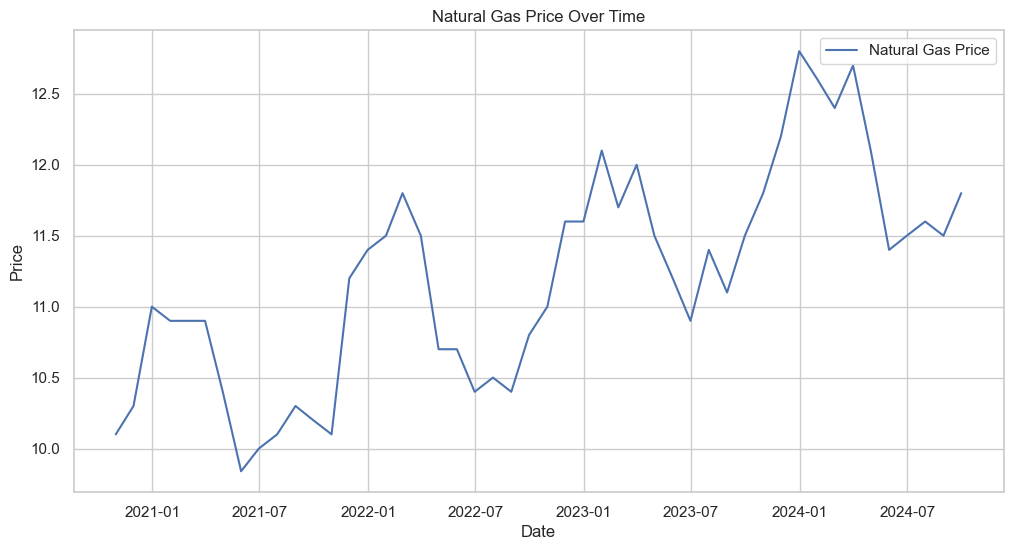

In [639]:
# Plot the natural gas prices over time
plt.figure(figsize=(12, 6))
plt.plot(data['Dates'], data['Prices'], label='Natural Gas Price')
plt.title('Natural Gas Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Seasonal Decomposition

Decompose the time series to observe the trend, seasonal, and residual components.

The seasonal decomposition can be expressed mathematically as:
\[ Y_t = T_t + S_t + R_t \]
where:
- \( Y_t \) is the observed time series.
- \( T_t \) is the trend component.
- \( S_t \) is the seasonal component.
- \( R_t \) is the residual (or irregular) component.

We use the `seasonal_decompose` function from `statsmodels` to perform this decomposition.


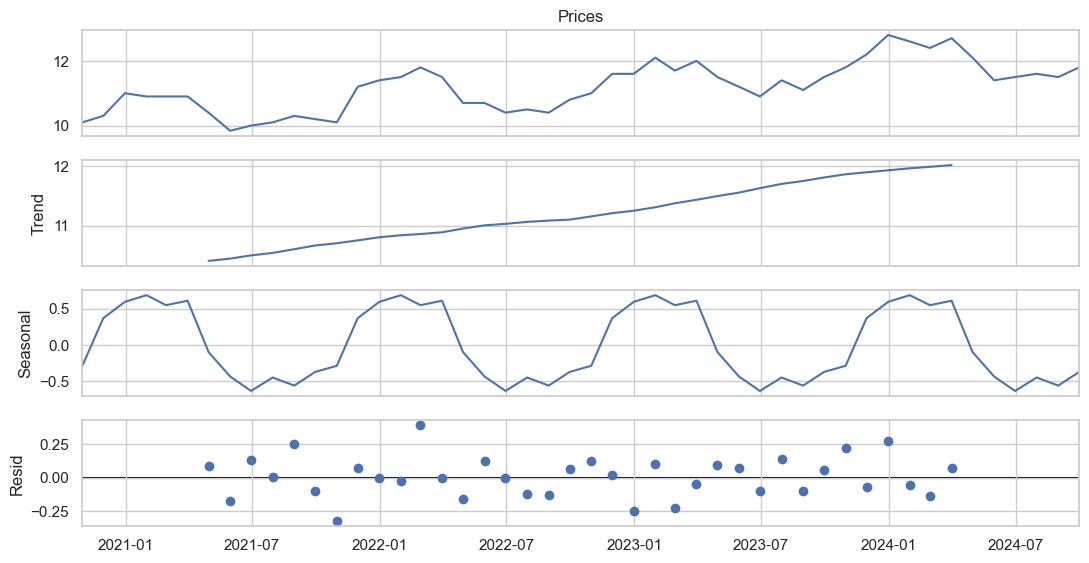

In [641]:
# Seasonal Decomposition
decomposition = sm.tsa.seasonal_decompose(data.set_index('Dates')['Prices'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

### Box Plots to Identify Seasonal Trends

Create box plots to identify any seasonal trends in the data.

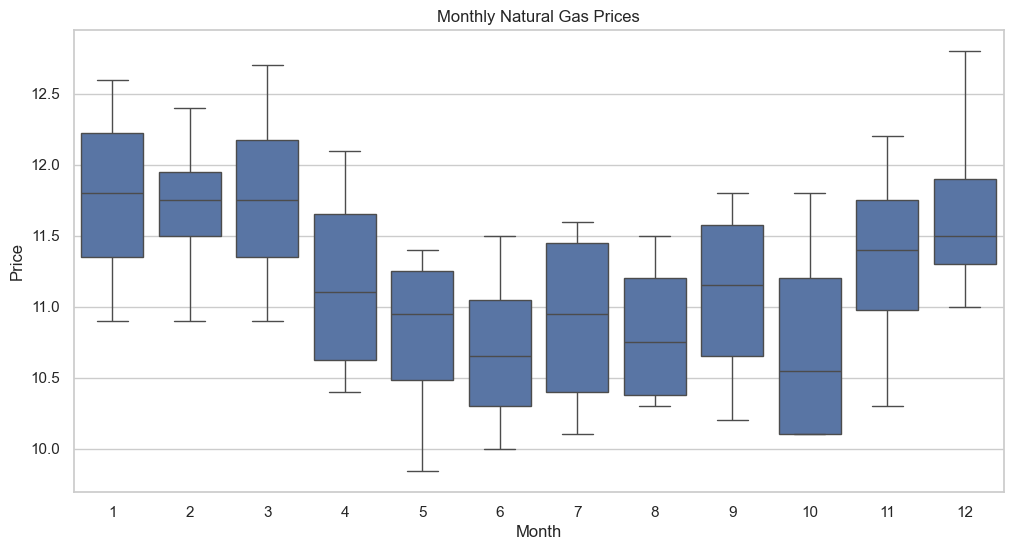

In [643]:
# Box plots to identify seasonal trends
data['Month'] = data['Dates'].dt.month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Prices', data=data)
plt.title('Monthly Natural Gas Prices')
plt.xlabel('Month')
plt.ylabel('Price')
plt.show()

### Rolling Statistics to Observe Moving Averages and Trends

Calculate and plot rolling means to observe moving averages and trends.

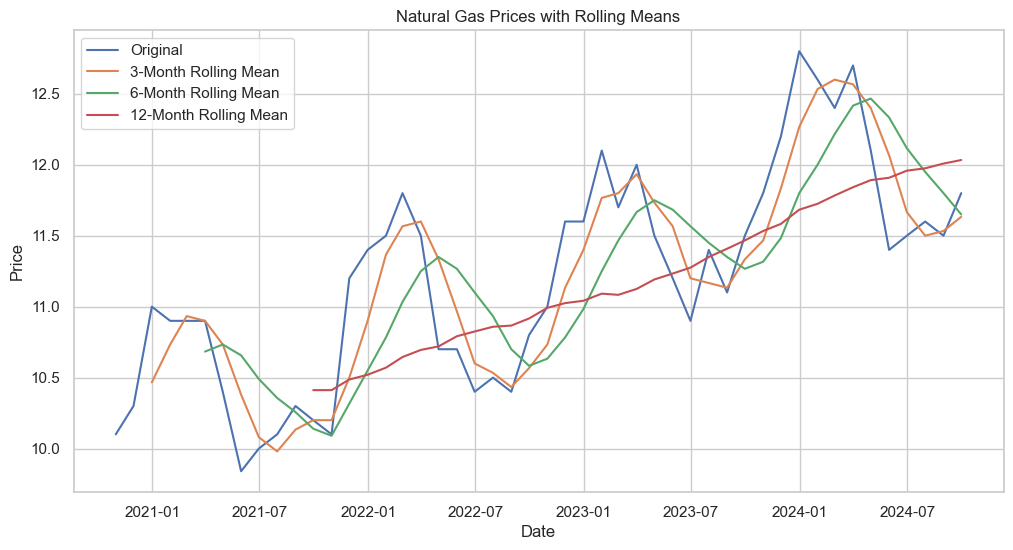

In [645]:
# Rolling statistics to observe moving averages and trends
data['Rolling_Mean_3'] = data['Prices'].rolling(window=3).mean()
data['Rolling_Mean_6'] = data['Prices'].rolling(window=6).mean()
data['Rolling_Mean_12'] = data['Prices'].rolling(window=12).mean()

plt.figure(figsize=(12, 6))
plt.plot(data['Dates'], data['Prices'], label='Original')
plt.plot(data['Dates'], data['Rolling_Mean_3'], label='3-Month Rolling Mean')
plt.plot(data['Dates'], data['Rolling_Mean_6'], label='6-Month Rolling Mean')
plt.plot(data['Dates'], data['Rolling_Mean_12'], label='12-Month Rolling Mean')
plt.title('Natural Gas Prices with Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Step 4: Stationarity Check

### Perform Augmented Dickey-Fuller (ADF) Test

Check if the time series is stationary using the ADF test.

The null hypothesis (\(H_0\)) of the ADF test is that the time series has a unit root, meaning it is non-stationary. The alternative hypothesis (\(H_1\)) is that the time series is stationary.

The test statistic is compared against critical values at different confidence levels. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that the series is stationary.


In [647]:
# Define the ADF hypothesis test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] <= 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary")

# Check stationarity of the original series
adf_test(data['Prices'])

ADF Statistic: 0.21807686169999468
p-value: 0.973257438844869
Critical Values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
The series is not stationary


### Differencing to Make the Series Stationary

Apply differencing to make the time series stationary and re-check with the ADF test.

Differencing a time series involves subtracting the previous observation from the current observation:
\[ Y'_t = Y_t - Y_{t-1} \]

If the series is still not stationary after first differencing, further differencing may be applied.

In [649]:
# Differencing to make the series stationary
data['Prices_diff'] = data['Prices'].diff()

# Drop NaN values from the differenced series
prices_diff = data['Prices_diff'].dropna()

In [650]:
# Run the ADF test
adf_test(prices_diff)

ADF Statistic: -6.844773557477348
p-value: 1.7541696852940523e-09
Critical Values: {'1%': -3.6209175221605827, '5%': -2.9435394610388332, '10%': -2.6104002410518627}
The series is stationary


### ACF and PACF Plots

Plot ACF and PACF to identify the order of the ARIMA model.

- The Autocorrelation Function (ACF) shows the correlation between the series and its lags.
- The Partial Autocorrelation Function (PACF) shows the correlation between the series and its lags after removing the effect of earlier lags.

These plots help in identifying the number of AR (Auto-Regressive) and MA (Moving Average) terms.


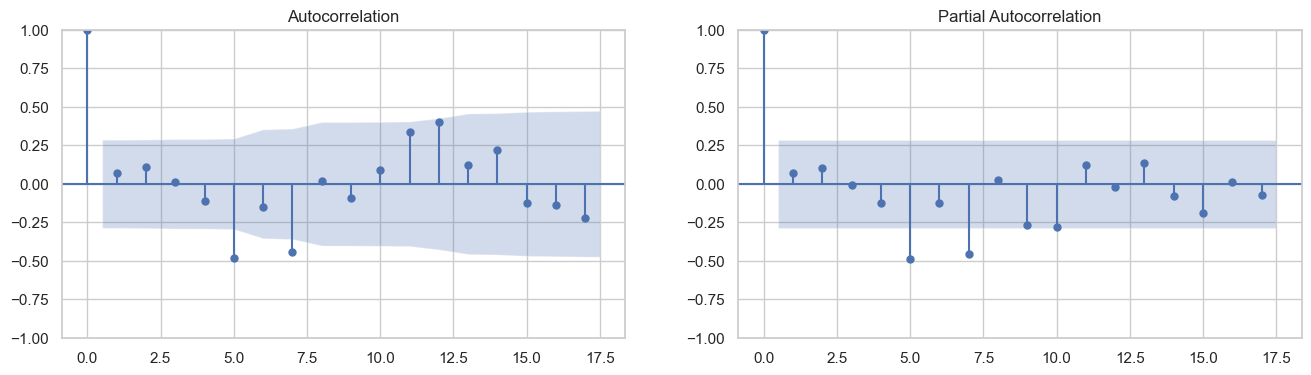

In [652]:
# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data['Prices_diff'].dropna(), ax=axes[0])
plot_pacf(data['Prices_diff'].dropna(), ax=axes[1])
plt.show()

## Step 5: Model Selection

### Auto ARIMA Model

Use auto ARIMA to find the best ARIMA model parameters.

The ARIMA model can be expressed as:
\[ Y_t = c + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \ldots + \phi_p Y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \ldots + \theta_q \epsilon_{t-q} \]
where:
- \( \phi \) are the coefficients for the AR terms.
- \( \theta \) are the coefficients for the MA terms.
- \( \epsilon_t \) is the white noise error term.

Auto ARIMA automates the process of finding the best parameters (p, d, q) by searching through a range of values.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=37.376, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=42.336, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46.741, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=39.693, Time=0.63 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=39.748, Time=1.43 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=38.552, Time=0.82 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=36.012, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=53.197, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=53.566, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=53.701, Time=0.16 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=53.674, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=51.953,

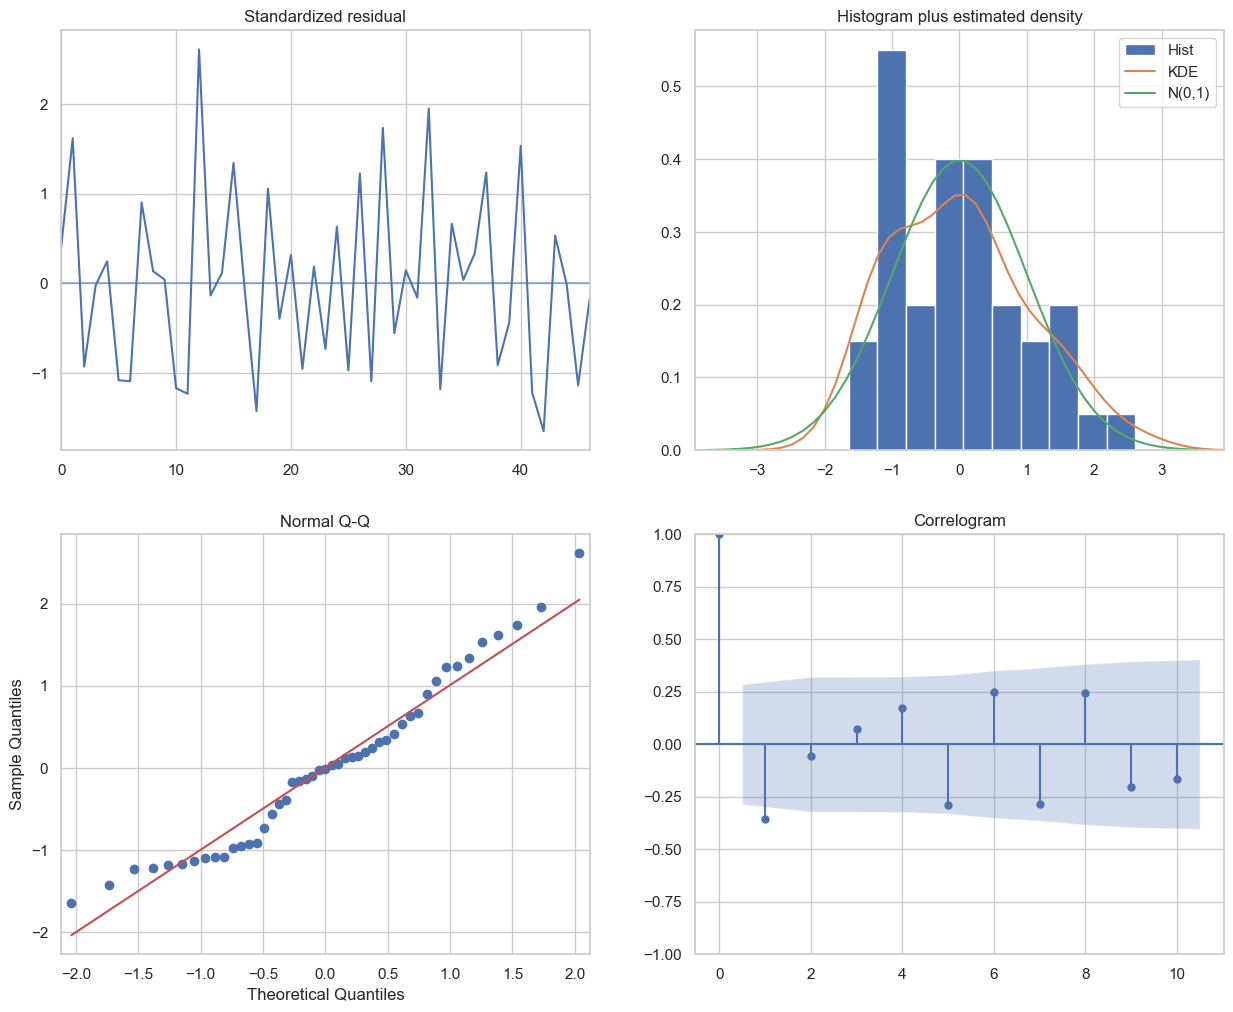

In [654]:
# Fit auto ARIMA model
model_auto_arima = auto_arima(data['Prices'], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Print the summary of the auto ARIMA model
auto_arima_summary = model_auto_arima.summary()

# Plot diagnostics 
fig = model_auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

## Step 6: Seasonal Differencing

Apply seasonal differencing and plot ACF and PACF for the seasonally differenced data.

Seasonal differencing involves subtracting the value from the same period in the previous season:
\[ Y'_t = Y_t - Y_{t-m} \]
where \( m \) is the seasonal period.

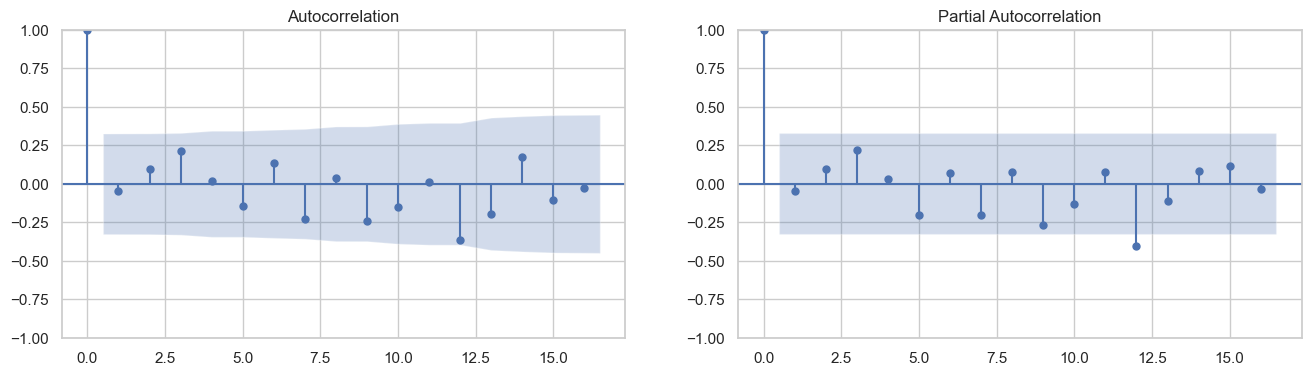

In [656]:
# Seasonal differencing
data['Prices_seasonal_diff'] = data['Prices'].diff(12).dropna()

# Seasonal ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data['Prices_seasonal_diff'].dropna(), ax=axes[0])
plot_pacf(data['Prices_seasonal_diff'].dropna(), ax=axes[1])
plt.show()

## Step 7: SARIMA Model

Fit and evaluate a SARIMA model.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54046D-01    |proj g|=  3.48180D-01

At iterate    5    f=  2.66187D-02    |proj g|=  7.23482D-02

At iterate   10    f=  1.45908D-02    |proj g|=  3.62008D-02

At iterate   15    f=  1.35447D-02    |proj g|=  2.51159D-02

At iterate   20    f=  1.33731D-02    |proj g|=  2.40671D-02

At iterate   25    f=  1.33589D-02    |proj g|=  7.74188D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     54      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


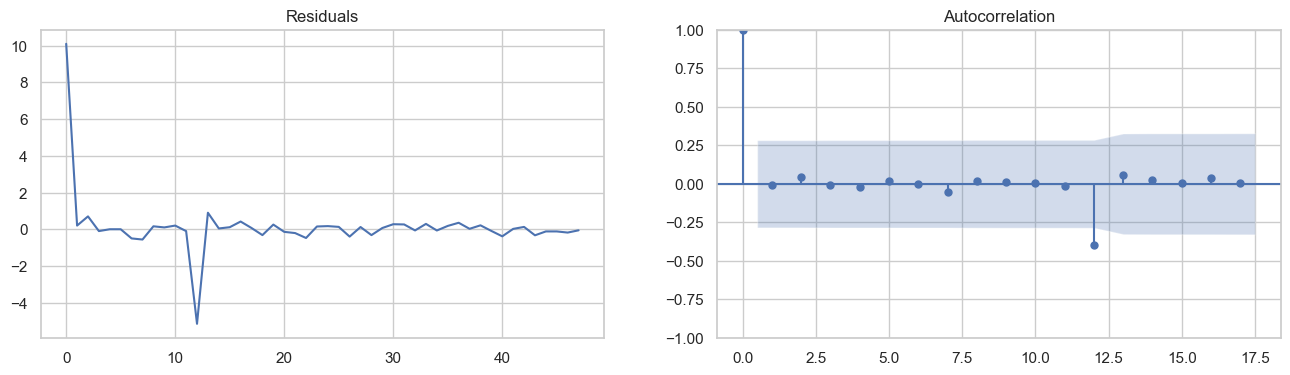

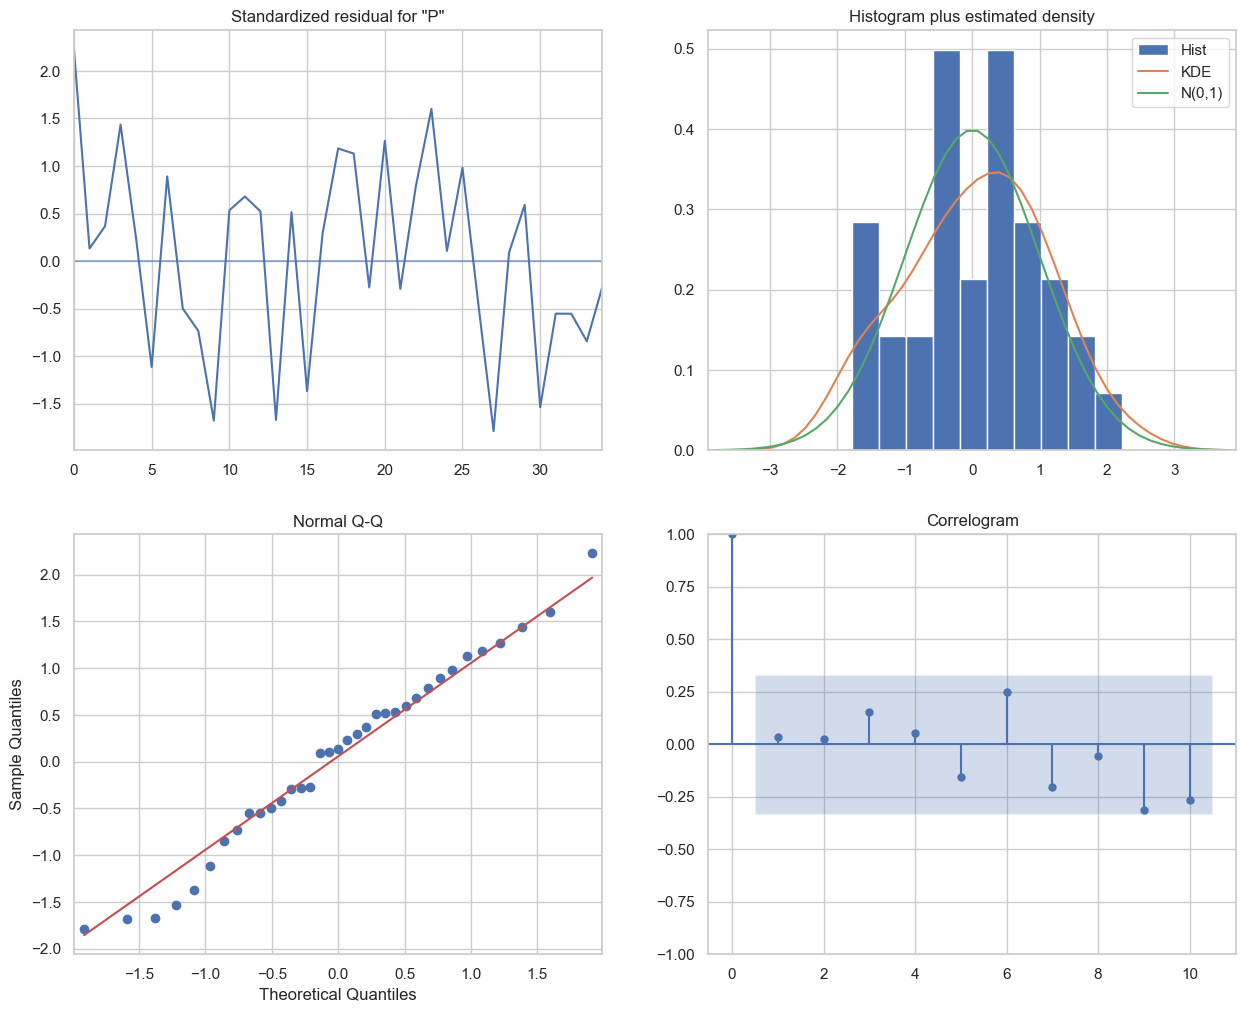

In [658]:
# Fit SARIMA model
model_sarima = SARIMAX(data['Prices'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results_sarima = model_sarima.fit()
print(results_sarima.summary())

# Residual analysis for SARIMA model
residuals_sarima = results_sarima.resid
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
residuals_sarima.plot(title="Residuals", ax=ax[0])
plot_acf(residuals_sarima, ax=ax[1])
plt.show()

# Diagnostic plots for SARIMA model
results_sarima.plot_diagnostics(figsize=(15, 12))
plt.show()

### Cross-Validation

Implement time series cross-validation to assess model performance.

In [660]:
# Define the cross-validation ARIMA function
def cross_validation_arima(data, order, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    mae, mse, rmse = [], [], []

    for train_index, test_index in tscv.split(data):
        train, test = data[train_index], data[test_index]
        model = SARIMAX(train, order=order, seasonal_order=(1, 1, 1, 12))
        model_fit = model.fit(disp=False)
        predictions = model_fit.forecast(steps=len(test))
        mae.append(mean_absolute_error(test, predictions))
        mse.append(mean_squared_error(test, predictions))
        rmse.append(np.sqrt(mean_squared_error(test, predictions)))

    return np.mean(mae), np.mean(mse), np.mean(rmse)

# Apply cross-validation to the selected ARIMA model
order = (2, 1, 2)
data_series = data['Prices'].values
mae_arima, mse_arima, rmse_arima = cross_validation_arima(data_series, order)

print(f'ARIMA Model - MAE: {mae_arima}, MSE: {mse_arima}, RMSE: {rmse_arima}')

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few obser

ARIMA Model - MAE: 0.690903634785524, MSE: 1.9941936676408019, RMSE: 0.907513812136951


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Step 8: Model Forecast

Plot the Forecast

We plot the observed natural gas prices along with the forecasted prices. The shaded region represents the 95% confidence interval for the forecasted values.

/var/folders/pd/b0tddw0j2k3gzyk88t7cxnc40000gn/T/ipykernel_69299/517107152.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=data['Dates'].iloc[-1], periods=forecast_steps, freq='M'),
/var/folders/pd/b0tddw0j2k3gzyk88t7cxnc40000gn/T/ipykernel_69299/517107152.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.fill_between(pd.date_range(start=data['Dates'].iloc[-1], periods=forecast_steps, freq='M'),


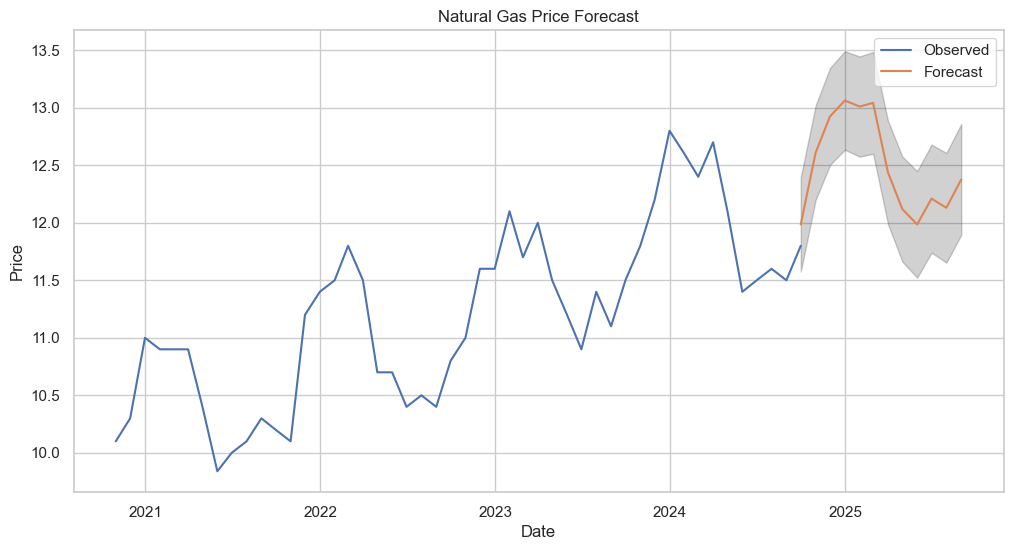

In [662]:
# Forecasting with the best SARIMA model
forecast_steps = 12  # Number of steps to forecast
forecast = results_sarima.get_forecast(steps=forecast_steps)
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Dates'], data['Prices'], label='Observed')
plt.plot(pd.date_range(start=data['Dates'].iloc[-1], periods=forecast_steps, freq='M'), 
         forecast.predicted_mean, label='Forecast')
plt.fill_between(pd.date_range(start=data['Dates'].iloc[-1], periods=forecast_steps, freq='M'), 
                 forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Price Forecast')
plt.legend()
plt.show()

## Conclusion

This analysis demonstrates the process of loading, visualising, and modelling time series data to forecast natural gas prices. The SARIMA model provides a reasonable forecast, which can be further refined with more data and advanced techniques.